In [1]:
import torch
import numpy as np
import pinot
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using backend: pytorch


In [18]:
# define the target
f = lambda x: torch.sin(x)

x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_tr = f(x_tr)
y_te = f(x_te)
y = f(x)

In [19]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Tanh(),
        torch.nn.Linear(50, 1))

kernel = pinot.inference.gp.deep_kernel.DeepKernel(
    net,
    base_kernel=pinot.inference.gp.kernels.RBF())

In [20]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
for _ in range(1000):
    opt.zero_grad()
    loss = kernel.loss(x_tr, y_tr).sum()
    loss.backward()
    print(loss)
    opt.step()

tensor(219.4614, grad_fn=<SumBackward0>)
tensor(219.0685, grad_fn=<SumBackward0>)
tensor(218.6176, grad_fn=<SumBackward0>)
tensor(218.1237, grad_fn=<SumBackward0>)
tensor(217.6070, grad_fn=<SumBackward0>)
tensor(217.0858, grad_fn=<SumBackward0>)
tensor(216.5789, grad_fn=<SumBackward0>)
tensor(216.1032, grad_fn=<SumBackward0>)
tensor(215.6716, grad_fn=<SumBackward0>)
tensor(215.2907, grad_fn=<SumBackward0>)
tensor(214.9598, grad_fn=<SumBackward0>)
tensor(214.6724, grad_fn=<SumBackward0>)
tensor(214.4189, grad_fn=<SumBackward0>)
tensor(214.1903, grad_fn=<SumBackward0>)
tensor(213.9800, grad_fn=<SumBackward0>)
tensor(213.7845, grad_fn=<SumBackward0>)
tensor(213.6019, grad_fn=<SumBackward0>)
tensor(213.4313, grad_fn=<SumBackward0>)
tensor(213.2715, grad_fn=<SumBackward0>)
tensor(213.1215, grad_fn=<SumBackward0>)
tensor(212.9804, grad_fn=<SumBackward0>)
tensor(212.8475, grad_fn=<SumBackward0>)
tensor(212.7220, grad_fn=<SumBackward0>)
tensor(212.6033, grad_fn=<SumBackward0>)
tensor(212.4909,

tensor(208.1900, grad_fn=<SumBackward0>)
tensor(208.1874, grad_fn=<SumBackward0>)
tensor(208.1848, grad_fn=<SumBackward0>)
tensor(208.1823, grad_fn=<SumBackward0>)
tensor(208.1798, grad_fn=<SumBackward0>)
tensor(208.1773, grad_fn=<SumBackward0>)
tensor(208.1748, grad_fn=<SumBackward0>)
tensor(208.1723, grad_fn=<SumBackward0>)
tensor(208.1699, grad_fn=<SumBackward0>)
tensor(208.1675, grad_fn=<SumBackward0>)
tensor(208.1652, grad_fn=<SumBackward0>)
tensor(208.1628, grad_fn=<SumBackward0>)
tensor(208.1605, grad_fn=<SumBackward0>)
tensor(208.1582, grad_fn=<SumBackward0>)
tensor(208.1559, grad_fn=<SumBackward0>)
tensor(208.1536, grad_fn=<SumBackward0>)
tensor(208.1513, grad_fn=<SumBackward0>)
tensor(208.1491, grad_fn=<SumBackward0>)
tensor(208.1469, grad_fn=<SumBackward0>)
tensor(208.1447, grad_fn=<SumBackward0>)
tensor(208.1425, grad_fn=<SumBackward0>)
tensor(208.1404, grad_fn=<SumBackward0>)
tensor(208.1382, grad_fn=<SumBackward0>)
tensor(208.1361, grad_fn=<SumBackward0>)
tensor(208.1339,

tensor(207.6269, grad_fn=<SumBackward0>)
tensor(207.6249, grad_fn=<SumBackward0>)
tensor(207.6230, grad_fn=<SumBackward0>)
tensor(207.6210, grad_fn=<SumBackward0>)
tensor(207.6190, grad_fn=<SumBackward0>)
tensor(207.6171, grad_fn=<SumBackward0>)
tensor(207.6151, grad_fn=<SumBackward0>)
tensor(207.6132, grad_fn=<SumBackward0>)
tensor(207.6113, grad_fn=<SumBackward0>)
tensor(207.6093, grad_fn=<SumBackward0>)
tensor(207.6074, grad_fn=<SumBackward0>)
tensor(207.6055, grad_fn=<SumBackward0>)
tensor(207.6035, grad_fn=<SumBackward0>)
tensor(207.6015, grad_fn=<SumBackward0>)
tensor(207.5995, grad_fn=<SumBackward0>)
tensor(207.5975, grad_fn=<SumBackward0>)
tensor(207.5954, grad_fn=<SumBackward0>)
tensor(207.5931, grad_fn=<SumBackward0>)
tensor(207.5906, grad_fn=<SumBackward0>)
tensor(207.5874, grad_fn=<SumBackward0>)
tensor(207.5834, grad_fn=<SumBackward0>)
tensor(207.5772, grad_fn=<SumBackward0>)
tensor(207.5675, grad_fn=<SumBackward0>)
tensor(207.5515, grad_fn=<SumBackward0>)
tensor(207.5261,

tensor(206.3405, grad_fn=<SumBackward0>)
tensor(206.3398, grad_fn=<SumBackward0>)
tensor(206.3391, grad_fn=<SumBackward0>)
tensor(206.3383, grad_fn=<SumBackward0>)
tensor(206.3376, grad_fn=<SumBackward0>)
tensor(206.3369, grad_fn=<SumBackward0>)
tensor(206.3362, grad_fn=<SumBackward0>)
tensor(206.3355, grad_fn=<SumBackward0>)
tensor(206.3347, grad_fn=<SumBackward0>)
tensor(206.3340, grad_fn=<SumBackward0>)
tensor(206.3333, grad_fn=<SumBackward0>)
tensor(206.3327, grad_fn=<SumBackward0>)
tensor(206.3320, grad_fn=<SumBackward0>)
tensor(206.3313, grad_fn=<SumBackward0>)
tensor(206.3306, grad_fn=<SumBackward0>)
tensor(206.3299, grad_fn=<SumBackward0>)
tensor(206.3293, grad_fn=<SumBackward0>)
tensor(206.3286, grad_fn=<SumBackward0>)
tensor(206.3279, grad_fn=<SumBackward0>)
tensor(206.3272, grad_fn=<SumBackward0>)
tensor(206.3265, grad_fn=<SumBackward0>)
tensor(206.3259, grad_fn=<SumBackward0>)
tensor(206.3253, grad_fn=<SumBackward0>)
tensor(206.3246, grad_fn=<SumBackward0>)
tensor(206.3239,

tensor(206.2209, grad_fn=<SumBackward0>)
tensor(206.2206, grad_fn=<SumBackward0>)
tensor(206.2202, grad_fn=<SumBackward0>)


In [21]:
y_hat_distribution = kernel.condition(x_tr, y_tr, x)

In [22]:
y_hat_distribution.sample().shape

torch.Size([375])

In [23]:
def plot():
    from pinot.inference.utils import confidence_interval
    from matplotlib import pyplot as plt

    plt.figure(figsize=(10, 6))
    # y_hat_distribution = pinot.inference.utils.condition_mixture(net, x, sampler=opt, n_samples=1000)

    nll = y_hat_distribution.log_prob(y).mean() / float(y.shape[0])

    plt.plot(x, y_hat_distribution.mean.detach().numpy(), c='k', linewidth=5)

    low, high = confidence_interval(y_hat_distribution, 0.95, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.1)
    
    low, high = confidence_interval(y_hat_distribution, 0.75, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.2)

    low, high = confidence_interval(y_hat_distribution, 0.50, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.3)

    low, high = confidence_interval(y_hat_distribution, 0.25, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, label='te')
    plt.scatter(x_tr, y_tr, label='tr')
    plt.legend()
    plt.ylim(-2, 2)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))

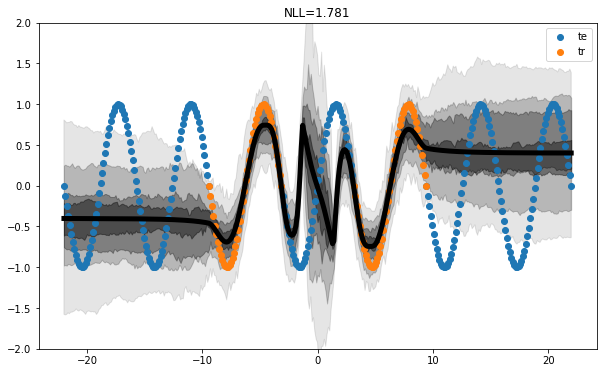

In [24]:
plot()